In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
plt.style.use('seaborn-bright')
# print(plt.style.available)

In [44]:
df = pd.read_csv('data/train_processed_2.csv')
df.head()

,age_in_yrs,income,application_underwriting_score,premium,perc_premium_paid_by_cash_credit,no_of_premiums_paid,count_3-6_months_late,count_6-12_months_late,count_more_than_12_months_late,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E,residence_area_type_Rural,residence_area_type_Urban,renewal
0,0.146,12.78,0.891,8.1017,0.429,0.19,0.0,0.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.463,12.66,1.000,9.7981,0.010,0.33,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.329,11.34,0.850,8.1017,0.917,0.09,2.0,3.0,1.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.256,12.43,0.960,9.1695,0.049,0.12,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.793,12.20,0.997,9.1695,0.052,0.17,0.0,0.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Split Test Data into Train and CV

In [45]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1].astype(int)
print(x.shape)
print(y.shape)

(79853, 16)
(79853,)


In [46]:
from sklearn.model_selection import train_test_split
trainx,cvx, trainy,cvy = train_test_split(x,y, test_size=0.1, random_state=42, stratify=y)

# After we randomly split the dataset, we've the following class proportions in percent: 
print('All:', np.bincount(y) / len(y) * 100.0)
print('Training:', np.bincount(trainy) / len(trainy) * 100.0)
print('Test:', np.bincount(cvy) / len(cvy) * 100.0)

All: [39.66037594 60.33962406]
Training: [39.66076224 60.33923776]
Test: [39.65689957 60.34310043]


## Modeling: Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(trainx,trainy)
print('Classification Score on trainx/y :', clf.score(trainx, trainy)) # Perfect score  1
print('Classification Score on trainx/y :', clf.score(cvx, cvy)) # Perfect score  1

Classification Score on trainx/y : 1.0
Classification Score on trainx/y : 1.0


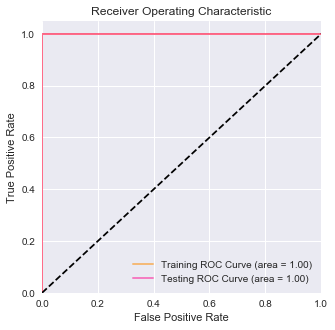

In [69]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Get just the probability of class in 0th-column and that implies getting the probability of "Not Renewing the Policy"
# trainy_prob = clf.predict_proba(trainx)[:,0] # Get just the probability of No-renewal (class in 0th-column)
# fpr, tpr, thresholds = roc_curve(trainy, trainy_prob, pos_label=1)
# roc_auc = auc(1-fpr, 1-tpr) # Because we want the P(renewing the policy) when we know the P(NOT renewing the policy)

# cvy_prob = clf.predict_proba(cvx)[:,0] # Get just the probability of class in first-column
# fpr_cv, tpr_cv, threshold_cv = roc_curve(cvy, cvy_prob, pos_label=1)
# roc_auc_cv = auc(1-fpr_cv, 1-tpr_cv)


# Get just the probability of class in 1st-column and that implies getting the probability of "Renewing the Policy"
trainy_prob = clf.predict_proba(trainx)[:,1] # Get just the probability of Renewal (class in 1st-column)
fpr, tpr, thresholds = roc_curve(trainy, trainy_prob, pos_label=1)
roc_auc = auc(fpr, tpr) # Because we want the P(renewing the policy)

cvy_prob = clf.predict_proba(cvx)[:,1] # Get just the probability of class in 1st-column, P()
fpr_cv, tpr_cv, threshold_cv = roc_curve(cvy, cvy_prob, pos_label=1)
roc_auc_cv = auc(fpr_cv, tpr_cv)


plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', alpha=0.5, lw=2, linestyle='-', label='Training ROC Curve (area = {0:.2f})'.format(roc_auc))
plt.plot(fpr_cv, tpr_cv, color='deeppink', alpha=0.5, lw=2, linestyle='-', label='Testing ROC Curve (area = {0:.2f})'.format(roc_auc_cv))
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [70]:
# In order to calculate the AUC, you need to have probabilities.
roc_auc_score(trainy, trainy_prob)

1.0

## Preliminary Pre-processing of TEST dataset


In [71]:
test_df = pd.read_csv('data/test.csv')
test_df.shape

(34224, 12)

In [72]:
test_df.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
0,649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,A,Rural,3300
1,81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,A,Urban,11700
2,70762,1.000,17170,186030,0.0,0.0,0.0,NaN,2,B,Urban,11700
3,53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,B,Rural,5400
4,15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,A,Rural,9600


In [51]:
test_df = test_df.rename(columns={'Income':'income',
                   'Count_3-6_months_late':'count_3-6_months_late', 
                   'Count_6-12_months_late':'count_6-12_months_late',
                   'Count_more_than_12_months_late':'count_more_than_12_months_late'
                  })
test_df.head(5)

,id,perc_premium_paid_by_cash_credit,age_in_days,income,count_3-6_months_late,count_6-12_months_late,count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
0,649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,A,Rural,3300
1,81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,A,Urban,11700
2,70762,1.000,17170,186030,0.0,0.0,0.0,NaN,2,B,Urban,11700
3,53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,B,Rural,5400
4,15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,A,Rural,9600


In [52]:
# test_df.drop(columns=['id'],axis=1,inplace=True) # Don't because it is requirerd for final submimssion
# test_df.head()
iddf = test_df['id']
print(iddf.shape)
test_df = test_df.iloc[:,1:]
test_df.head()

(34224,)


,perc_premium_paid_by_cash_credit,age_in_days,income,count_3-6_months_late,count_6-12_months_late,count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
0,0.001,27384,51150,0.0,0.0,0.0,99.89,7,A,Rural,3300
1,0.124,23735,285140,0.0,0.0,0.0,98.93,19,A,Urban,11700
2,1.000,17170,186030,0.0,0.0,0.0,NaN,2,B,Urban,11700
3,0.198,16068,123540,0.0,0.0,0.0,99.00,11,B,Rural,5400
4,0.041,10591,200020,1.0,0.0,0.0,99.17,14,A,Rural,9600


In [53]:
test_df['age_in_yrs'] = (test_df['age_in_days'] / 365).astype(int)
test_df.drop(columns=['age_in_days'],axis=1, inplace=True)
test_df.head()

,perc_premium_paid_by_cash_credit,income,count_3-6_months_late,count_6-12_months_late,count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,age_in_yrs
0,0.001,51150,0.0,0.0,0.0,99.89,7,A,Rural,3300,75
1,0.124,285140,0.0,0.0,0.0,98.93,19,A,Urban,11700,65
2,1.000,186030,0.0,0.0,0.0,NaN,2,B,Urban,11700,47
3,0.198,123540,0.0,0.0,0.0,99.00,11,B,Rural,5400,44
4,0.041,200020,1.0,0.0,0.0,99.17,14,A,Rural,9600,29


In [54]:
print(test_df.isnull().sum())
tmp = test_df[['count_3-6_months_late', 'count_6-12_months_late', 'count_more_than_12_months_late']].fillna(0)
test_df.update(tmp)
print(test_df.isnull().sum())

perc_premium_paid_by_cash_credit       0
income                                 0
count_3-6_months_late                 31
count_6-12_months_late                31
count_more_than_12_months_late        31
application_underwriting_score      1323
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
premium                                0
age_in_yrs                             0
dtype: int64
perc_premium_paid_by_cash_credit       0
income                                 0
count_3-6_months_late                  0
count_6-12_months_late                 0
count_more_than_12_months_late         0
application_underwriting_score      1323
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
premium                                0
age_in_yrs                             0
dtype: int64


In [55]:
test_df.update( test_df['application_underwriting_score'].fillna(99.89) ) # Filling with mode value of test set
test_df.isnull().sum()

perc_premium_paid_by_cash_credit    0
income                              0
count_3-6_months_late               0
count_6-12_months_late              0
count_more_than_12_months_late      0
application_underwriting_score      0
no_of_premiums_paid                 0
sourcing_channel                    0
residence_area_type                 0
premium                             0
age_in_yrs                          0
dtype: int64

## More Pre-processing of TEST dataset


In [56]:
test_df['income'] = test_df['income'].apply(np.log).round(2)

In [57]:
from sklearn import preprocessing
data_scalar = preprocessing.MinMaxScaler()

test_df['age_in_yrs'] = data_scalar.fit_transform(test_df[['age_in_yrs']]).flatten().round(3)
test_df['application_underwriting_score'] = data_scalar.fit_transform(test_df[['application_underwriting_score']]).flatten().round(3)
test_df['no_of_premiums_paid'] = data_scalar.fit_transform(test_df[['no_of_premiums_paid']]).flatten().round(2)
test_df['premium'] = test_df['premium'].apply(np.log).round(4)

In [58]:
# Importing  utility function categorize from util.py defined in this directory of project
from util import categorize

tmp_df = categorize(test_df[['sourcing_channel']])
test_df = test_df.join(tmp_df)

tmp_df = categorize(test_df[['residence_area_type']])
test_df = test_df.join(tmp_df)

test_df.drop(['sourcing_channel', 'residence_area_type'], axis=1, inplace=True)

prefix : sourcing_channel_
prefix : residence_area_type_


In [59]:
test_df.head()

,perc_premium_paid_by_cash_credit,income,count_3-6_months_late,count_6-12_months_late,count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,age_in_yrs,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E,residence_area_type_Rural,residence_area_type_Urban
0,0.001,10.84,0.0,0.0,0.0,1.000,0.09,8.1017,0.701,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.124,12.56,0.0,0.0,0.0,0.880,0.30,9.3673,0.571,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000,12.13,0.0,0.0,0.0,1.000,0.00,9.3673,0.338,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.198,11.72,0.0,0.0,0.0,0.889,0.16,8.5942,0.299,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.041,12.21,1.0,0.0,0.0,0.910,0.21,9.1695,0.104,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [60]:
test_df = test_df[['age_in_yrs', 
               'income', 
               'application_underwriting_score', 
               'premium',
               'perc_premium_paid_by_cash_credit', 
               'no_of_premiums_paid',
               'count_3-6_months_late', 'count_6-12_months_late', 'count_more_than_12_months_late', 
               'sourcing_channel_A', 'sourcing_channel_B', 'sourcing_channel_C', 'sourcing_channel_D', 'sourcing_channel_E', 
               'residence_area_type_Rural', 'residence_area_type_Urban',
               ]]

In [61]:
test_df.head()

,age_in_yrs,income,application_underwriting_score,premium,perc_premium_paid_by_cash_credit,no_of_premiums_paid,count_3-6_months_late,count_6-12_months_late,count_more_than_12_months_late,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E,residence_area_type_Rural,residence_area_type_Urban
0,0.701,10.84,1.000,8.1017,0.001,0.09,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.571,12.56,0.880,9.3673,0.124,0.30,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.338,12.13,1.000,9.3673,1.000,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.299,11.72,0.889,8.5942,0.198,0.16,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.104,12.21,0.910,9.1695,0.041,0.21,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [64]:
# testx = test_df.iloc[:,:-1]
# testy = test_df.iloc[:,-1].astype(int)
# print(testx.shape)
# print(testy.shape)
testx = test_df
print(testx.shape)

(34224, 16)


## Summary
Following pre-procecssing activities are done as part of this deliverable/notebook:
1. Preprocess by applying np.log on the following columns:
    1.1 income
    1.2 premium
2. Pre-process with MinMaxScalara() the following columns: 
    2.1 age_in_yrs, 
    2.2 application_underwriting_score
    2.3 no_of_premiums_paid
3. Pre-process Feature Categories with LabelEncoder and OneHotEncoder on the following columns: 
    3.1 sourcing_channel, 
    3.2 residence_area_type

## Part A

The base probability of receiving a premium on a policy without considering any incentive.

The probabilities predicted by the participants would be evaluated using AUC ROC score.

In [73]:
# testy_prob = clf.predict_proba(testx)[:,1] # Get just the probability of renewal (class in 1st-column)
# fpr_test, tpr_test, threshold_test = roc_curve(??, testy_prob, pos_label=1)
# roc_auc_test = auc(fpr_test, tpr_test)

In [93]:
testy = clf.predict(testx)
testy_prob = pd.DataFrame(testy_prob)[1].round(2)

In [97]:
finaldf = pd.concat([iddf.to_frame(), testy_prob],
                    axis=1)
finaldf.head()

,id,1
0,649,1.0
1,81136,0.0
2,70762,0.0
3,53935,1.0
4,15476,1.0


## Part  B

The monthly incentives you will provide on each policy to maximize the net revenue based on the provided formulae in the problem statement

In [ ]:
# ??